In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax

def load_data(path, annotations):
    images = []
    labels = []

    with open(annotations, 'r') as file:
        annotations = json.load(file)

    for annotation in annotations:
        img = keras.preprocessing.image.load_img(
            os.path.join(path, f'image_id_{annotation["image_id"]:03}.jpg'),
            target_size=(224, 224)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

        labels.append(annotation['category_id'] - 1)

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_data('train/train', 'train_annotations.json')
valid_images, valid_labels = load_data('valid/valid', 'valid_annotations.json')


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

class_count=2
lr= 0.001
img_shape=(224,224,3)
epochs = 10

train_labels = to_categorical(train_labels, num_classes=class_count)
valid_labels = to_categorical(valid_labels, num_classes=class_count)

datagen = ImageDataGenerator(
        rotation_range=45,
        zoom_range = 0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(train_images)

base_model = tf.keras.applications.ResNet50(
    weights = "imagenet",
    input_shape = img_shape,
    include_top = False,
)

base_model.trainable=True

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(rate=0.2, seed=42),
    Dense(256,
          activation = 'relu',
          kernel_regularizer = regularizers.l2(0.02),
          activity_regularizer = regularizers.l1(0.02),
        ),
    Dropout(rate=0.2, seed=24),
    Dense(2, activation='softmax')
])

model.compile(
    Adamax(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

# Train the model
hist = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          validation_data=(valid_images, valid_labels),
          steps_per_epoch=len(train_images) / 32, epochs=epochs)

model.save('resNet50_model.h5')

val_loss, val_acc = model.evaluate(valid_images, valid_labels, verbose=2)

print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")

# Predict the labels of the validation data
pred = model.predict(valid_images)
pred_labels = np.argmax(pred, axis=1)


94765736/94765736 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 - 5s - loss: 1.6208 - accuracy: 0.9306 - 5s/epoch - 2s/step
Validation loss: 1.6208332777023315
Validation accuracy: 0.9305555820465088
3/3 [==============================] - 7s 2s/step


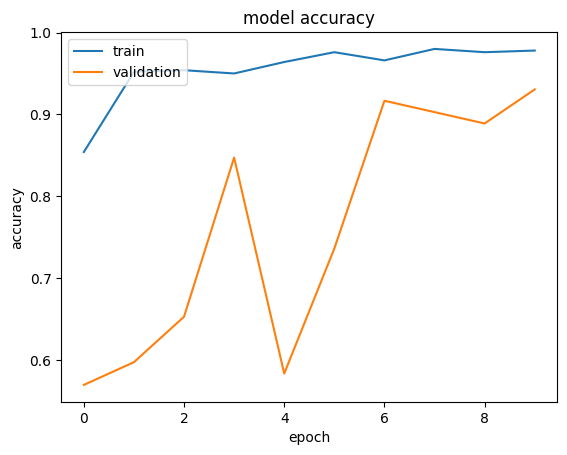

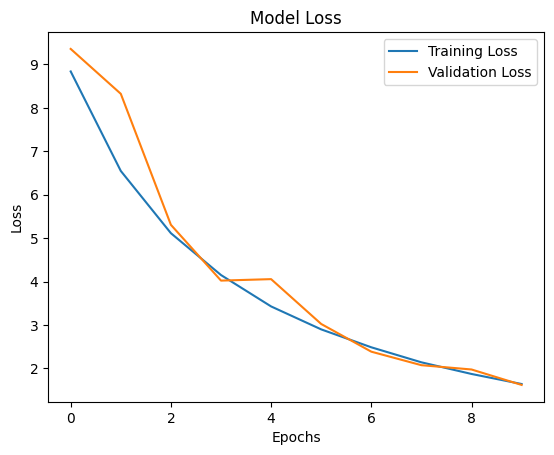

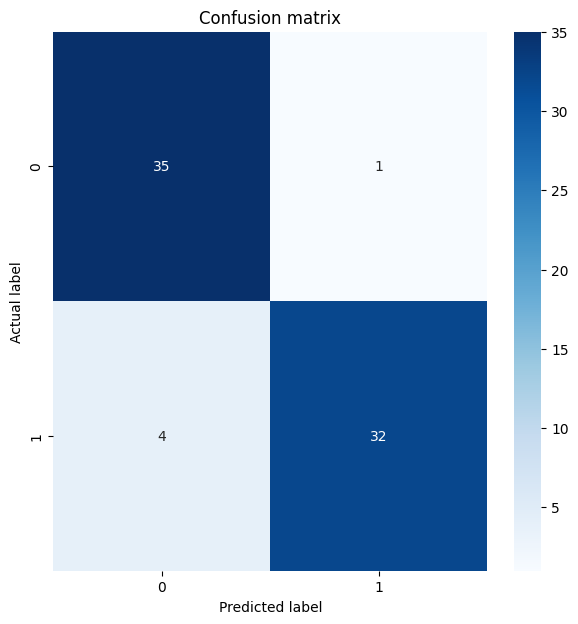

In [3]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = np.argmax(valid_labels, axis=1)

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [4]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('ResNet50_model.h5')

pred_probs = model.predict(valid_images)
preds = np.argmax(pred_probs, axis=1)

true_labels = np.argmax(valid_labels, axis=1)

report = classification_report(true_labels, preds, target_names=["Penguin", "Turtle"])
print(report)


3/3 [==============================] - 7s 2s/step
              precision    recall  f1-score   support

     Penguin       0.90      0.97      0.93        36
      Turtle       0.97      0.89      0.93        36

    accuracy                           0.93        72
   macro avg       0.93      0.93      0.93        72
weighted avg       0.93      0.93      0.93        72

